## Data Preperation 

* Many of the columns are just repeated the values, changed the column data type to categorical data type in this way the the rows are just references to these values.

* Using the Parquet file type with PyArrow (or fast Parquet) . The parquet file encodes our data types and it is also lighter and much faster to load. Pandas will now use PyArrow in the backend  now the whole BHB data set can be loaded and manipulated easily.

PyArrow
```Shell
conda install -c conda-forge pyarrow
```

In [1]:
import os
import pandas as pd
from pathlib import Path

cpu_model = !sed '5!d' /proc/cpuinfo
n_cpus=os.cpu_count()

print(cpu_model, '\n CPUS:', n_cpus)

data_folder = Path(r'D:\iorio+22_Zenodo_repository_V2\iorio+22_Zenodo_repository_V2\data_from_simulations\simulation_F')
data_path = Path(data_folder,'BHBHm.csv')
df = pd.read_csv(Path(data_folder,'BHBHm.csv'))



["'sed' is not recognized as an internal or external command,", 'operable program or batch file.'] 
 CPUS: 16


In [2]:
df.columns
df

,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
...,...,...,...,...,...
159008,10.57255,10.394180,0.0300,3.0,0.983129
159009,10.41027,9.384505,0.0300,3.0,0.901466
159010,7.55398,6.708311,0.0300,5.0,0.888050
159011,10.57255,10.394180,0.0300,5.0,0.983129


### This  is innefficent as we don't actually need all of these columns

In [ ]:
# Select relevant columns
df = df[["Mass_0", "Mass_1", "Z", "alpha"]]

# Convert 'alpha' to float
df['alpha'] = df['alpha'].astype(float)

# Swap masses if Mass_1 > Mass_0
df.loc[df['Mass_1'] > df['Mass_0'], ['Mass_0', 'Mass_1']] = df.loc[df['Mass_1'] > df['Mass_0'], ['Mass_1', 'Mass_0']].values

# Calculate mass ratio q
df['q'] = df['Mass_1'] / df['Mass_0']

#drop the qs that eqaul to 1


#sth silly but urgent
# df[['Mass_1', 'q']] = df[['q', 'Mass_1']].values

# Save to CSV
df.to_csv(data_path, index=False)



C:\Users\Asus\AppData\Local\Temp\ipykernel_19708\1271520514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alpha'] = df['alpha'].astype(float)


### Better yet to not load the extra columns at all

In [4]:
df=pd.read_csv(data_path, usecols = ['Mass_0','q','Z','alpha','Mass_1'])
df

,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
...,...,...,...,...,...
159008,10.57255,10.394180,0.0300,3.0,0.983129
159009,10.41027,9.384505,0.0300,3.0,0.901466
159010,7.55398,6.708311,0.0300,5.0,0.888050
159011,10.57255,10.394180,0.0300,5.0,0.983129


Make the repetitive columns categorical

In [5]:
df['alpha'] = df.alpha.astype('category')
df['Z'] = df.Z.astype('category')
df.to_parquet('BHBHm.pq')

In [6]:
old_size=os.stat(data_path).st_size
new_size=os.stat('BHBHm.pq').st_size
print("file now", round((new_size/old_size)*100), '% of the original size')

file now 35 % of the original size


## Reading Parquet Files
```Python
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('BHNSm.pq') 
first_ten_rows = next(pf.iter_batches(batch_size = 30)) 
df = pa.Table.from_batches([first_ten_rows]).to_pandas() 
df
```


In [7]:
pd.read_parquet('BHBHm.pq')

,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
...,...,...,...,...,...
159008,10.57255,10.394180,0.0300,3.0,0.983129
159009,10.41027,9.384505,0.0300,3.0,0.901466
159010,7.55398,6.708311,0.0300,5.0,0.888050
159011,10.57255,10.394180,0.0300,5.0,0.983129


In [8]:
def read_rows(file, nrows=10, skiprows=1):  
    from pyarrow.parquet import ParquetFile
    import pyarrow as pa 
    pf = ParquetFile(file) 
    batch_list=list(pf.iter_batches(batch_size = nrows))
    nbatch=len(batch_list)
    nskip=int(skiprows/nrows)
    df = pa.Table.from_batches([batch_list[nskip]]).to_pandas()
    #could write something to open up batches either side and make new df
    #not teh most efficent
    #rounds to closed batch
    return df

read_rows('BHBHm.pq')

,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
5,26.64688,14.374020,0.0001,0.5,0.539426
6,16.52531,6.289704,0.0001,0.5,0.380610
7,15.85697,14.084660,0.0001,0.5,0.888231
8,21.75281,18.246350,0.0001,0.5,0.838804
9,40.83927,36.232790,0.0001,0.5,0.887205


In [9]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('BHBHm.pq') 
#for all rows
df = pf.read().to_pandas()
#first_ten_rows = next(pf.iter_batches(batch_size = 900)) 
#df = pa.Table.from_batches([first_ten_rows]).to_pandas() 
df

#print max of alpha
df.q.max()



1.0

           Mass_0     Mass_1       Z  alpha         q
0      -31.374224  15.805690  0.0001    0.5  0.401534
1      -14.723908  25.701310  0.0001    0.5  0.248489
2      -23.430758  20.099740  0.0001    0.5  0.302811
3      -13.639354  25.073250  0.0001    0.5  0.201514
4      -30.789373   7.264607  0.0001    0.5 -0.092394
...           ...        ...     ...    ...       ...
159008 -42.485907  10.394180  0.0300    3.0  0.663865
159009 -42.789526   9.384505  0.0300    3.0  0.425869
159010 -48.814770   6.708311  0.0300    5.0  0.402218
159011 -42.485907  10.394180  0.0300    5.0  0.663865
159012 -42.789526   9.384505  0.0300    5.0  0.425869

[159013 rows x 5 columns]


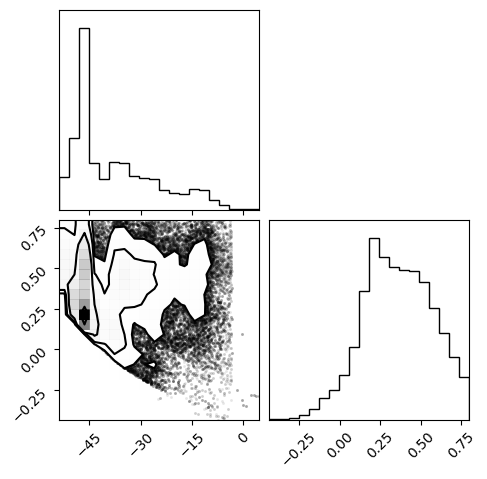

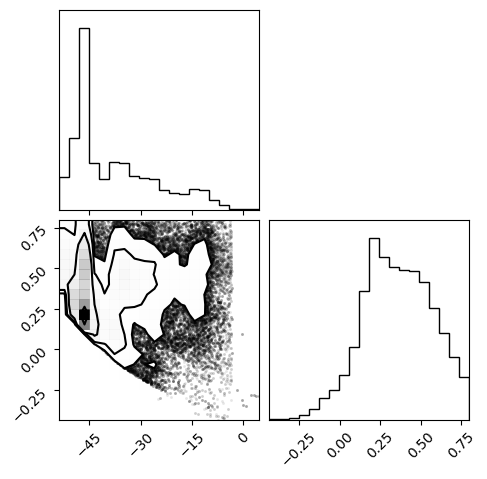

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import erfinv
from figaro.transform import transform_to_probit, transform_from_probit

# dataframew
# df = pd.DataFrame([Mass_0, Mass_1])


# Define bounds
bounds = np.array([[0.0, 100.0], [0.0, 1.01]])  

data_array = df[['Mass_0','q']].values

transformed_data = transform_to_probit(data_array, bounds)

transformed_df = df 

transformed_df['Mass_0'] = transformed_data[:,0]
transformed_df['q'] = transformed_data[:,1]

# max of transformed_df['q']



# Display the transformed DataFrame
print(transformed_df)

from corner import corner
corner(transformed_data)
#ss = transform_from_probit(transformed_data, bounds)

In [11]:
#spliting the file into 3 parts for train test and validation
from sklearn.model_selection import train_test_split
#df=pd.read_parquet('BHBHm.pq')
train, test = train_test_split(transformed_df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.2, random_state=42)
train.to_parquet('train.pq')
test.to_parquet('test.pq')
valid.to_parquet('valid.pq')
